# Varying the Infall Parameters

Several free parameters of the two-infall model affect the agreement with the data - namely, 
the first infall timescale $\tau_1$, the second infall timescale $\tau_2$, and
the onset of the second infall $t_{\rm max}$. In this notebook we explore the effect
of varying these parameters on model predictions at several different yield scales.

Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import vice

from apogee_sample import APOGEESample
from utils import twoinfall_onezone, get_bin_centers
from multizone.src import models, outflows
from _globals import END_TIME, ONEZONE_DEFAULTS, TWO_COLUMN_WIDTH
from track_and_mdf import setup_axes, plot_vice_onezone
import paths

Global variables

In [2]:
RADIUS = 8.
ZONE_WIDTH = 2.
LOCAL_DISK_RATIO = 0.12 # local thick-to-thin disk mass ratio
# convert between parameter keyword names and fancy labels
LABELS = {
    'first_timescale': '\\tau_1',
    'second_timescale': '\\tau_2',
    'onset': 't_{\\rm max}'
}
GRIDSIZE = 30
SMOOTH_WIDTH = 0.05

plt.style.use(paths.styles / 'paper.mplstyle')

Useful functions

In [3]:
def vary_param(subfig, first_timescale=1., second_timescale=10., onset=4.,
               local_disk_ratio=LOCAL_DISK_RATIO, label_index=None, 
               cmap_name=None, verbose=False, eta_func=outflows.yZ1, 
               fiducial_index=0, **kwargs):
    """
    Plot a series of onezone model outputs, varying one parameter of the 
    two-infall model while holding the others fixed.
    
    Parameters
    ----------
    subfig : matplotlib.figure.Figure
        Figure or subfigure in which to generate the axes.
    first_timescale : float, optional
        Timescale of the first infall in Gyr. If a list is passed, assumes
        this is the variable parameter and the others should be held fixed.
        The default is 0.1.
    second_timescale : float, optional
        Timescale of the second infall in Gyr. The default is 3.
    onset : float, optional
        Onset time of the second infall in Gyr. The default is 3.
    label_index : int, optional
        Index of track to add time labels to. If None, no time labels are added.
        The default is None.
    cmap_name : str, optional
        Name of colormap to draw line colors from. If None, line colors are
        drawn from the default prop color cycle. The default is None.
    verbose : bool, optional
        Whether to print verbose output to terminal.
    fiducial_index : int, optional
        Index of the fiducial parameter in the given list of parameter values.
        The associated line will be colored black. The default is 0.
    **kwargs passed to track_and_mdf.setup_axes()
    """
    param_dict = {
        'first_timescale': first_timescale, 
        'second_timescale': second_timescale, 
        'onset': onset
    }
    var = None
    other_params = ''
    for i, param in enumerate(param_dict.keys()):
        value = param_dict[param]
        if isinstance(value, list):
            if var is not None:
                raise ValueError('Too many variable parameters.')
            values = value
            var = param
        else:
            other_params += '$%s=%s$ Gyr\n' % (LABELS[param], value)
    if var is None:
        raise ValueError('Please specify one variable parameter.')
    axs = setup_axes(subfig, xlabel='[Fe/H]', **kwargs)

    dt = ONEZONE_DEFAULTS['dt']
    simtime = np.arange(0, END_TIME + dt, dt)
    area = np.pi * ((RADIUS + ZONE_WIDTH/2)**2 - (RADIUS - ZONE_WIDTH/2)**2)
    # Prescription for disk surface density as a function of radius
    diskmodel = models.diskmodel.two_component_disk.from_local_ratio(
        local_ratio = local_disk_ratio
    )
    # Outflow mass-loading factor
    eta = eta_func(RADIUS)

    for i, val in enumerate(values):
        param_dict[var] = val
        # Line color
        if i == fiducial_index:
            color = 'k'
        elif cmap_name is not None:
            cmap = plt.get_cmap(cmap_name)
            color = cmap((i+0.5) / len(values))
        else:
            color = None
        # Run one-zone model
        name = output_name(*param_dict.values())
        ifr = twoinfall_onezone(
            RADIUS, 
            diskmodel=diskmodel,
            mass_loading=eta_func, 
            dt=dt, 
            dr=ZONE_WIDTH, 
            **param_dict
        )
        sz = vice.singlezone(name=name,
                             func=ifr, 
                             mode='ifr',
                             **ONEZONE_DEFAULTS)
        sz.tau_star = models.twoinfall_sf_law(area, onset=param_dict['onset'])
        sz.eta = eta
        sz.run(simtime, overwrite=True)
        plot_vice_onezone(name, 
                          xcol='[fe/h]',
                          fig=subfig, axs=axs, 
                          linestyle='-', 
                          color=color, 
                          label=f'{val:.1f}', 
                          marker_labels=(i==label_index),
                          markers=[0.3, 1, 3, 6, 10])
        if verbose:
            print('Value:', val)
            print('Eta:', eta)
            # Thick-to-thin ratio
            hist = vice.history(name)
            onset_idx = int(ifr.onset / dt)
            thick_disk_mass = hist['mstar'][onset_idx-1]
            thin_disk_mass = hist['mstar'][-1] - thick_disk_mass
            print('Thick-to-thin ratio:', thick_disk_mass / thin_disk_mass)

    # Adjust axis limits
    axs[1].set_ylim(bottom=0)
    axs[2].set_xlim(left=0)
    axs[0].legend(frameon=False, loc='lower left', 
                  title='$%s$ [Gyr]' % LABELS[var])
    
    # Label other param values
    axs[0].text(0.95, 0.95, other_params, ha='right', va='top',
                transform=axs[0].transAxes)

    return axs


def output_name(tau1, tau2, onset, parent_dir=paths.data/'onezone'/'params'):
    if not parent_dir.exists():
        parent_dir.mkdir(parents=True)
    name = f'first{int(tau1*10):02d}_second{int(tau2)}_onset{int(onset)}'
    return str(parent_dir / name)

## Empirical yield scale $(y/Z_\odot = 1)$

Below, we compare gas abundance tracks in the [O/Fe]-[Fe/H] plane for one-zone GCE models with different infall parameters. In each panel, one parameter is varied according to the legend, while the other two are held fixed. Theopen symbols along each curve mark logarithmic steps in time, as denoted in panel (b). The marginal panels show corresponding stellar abundance distributions, which are convolved with a Gaussian kernel for visual clarity. All models are run at $R=8$ kpc. The black curves are for the fiducial set of parameters, and are the same in each panel.

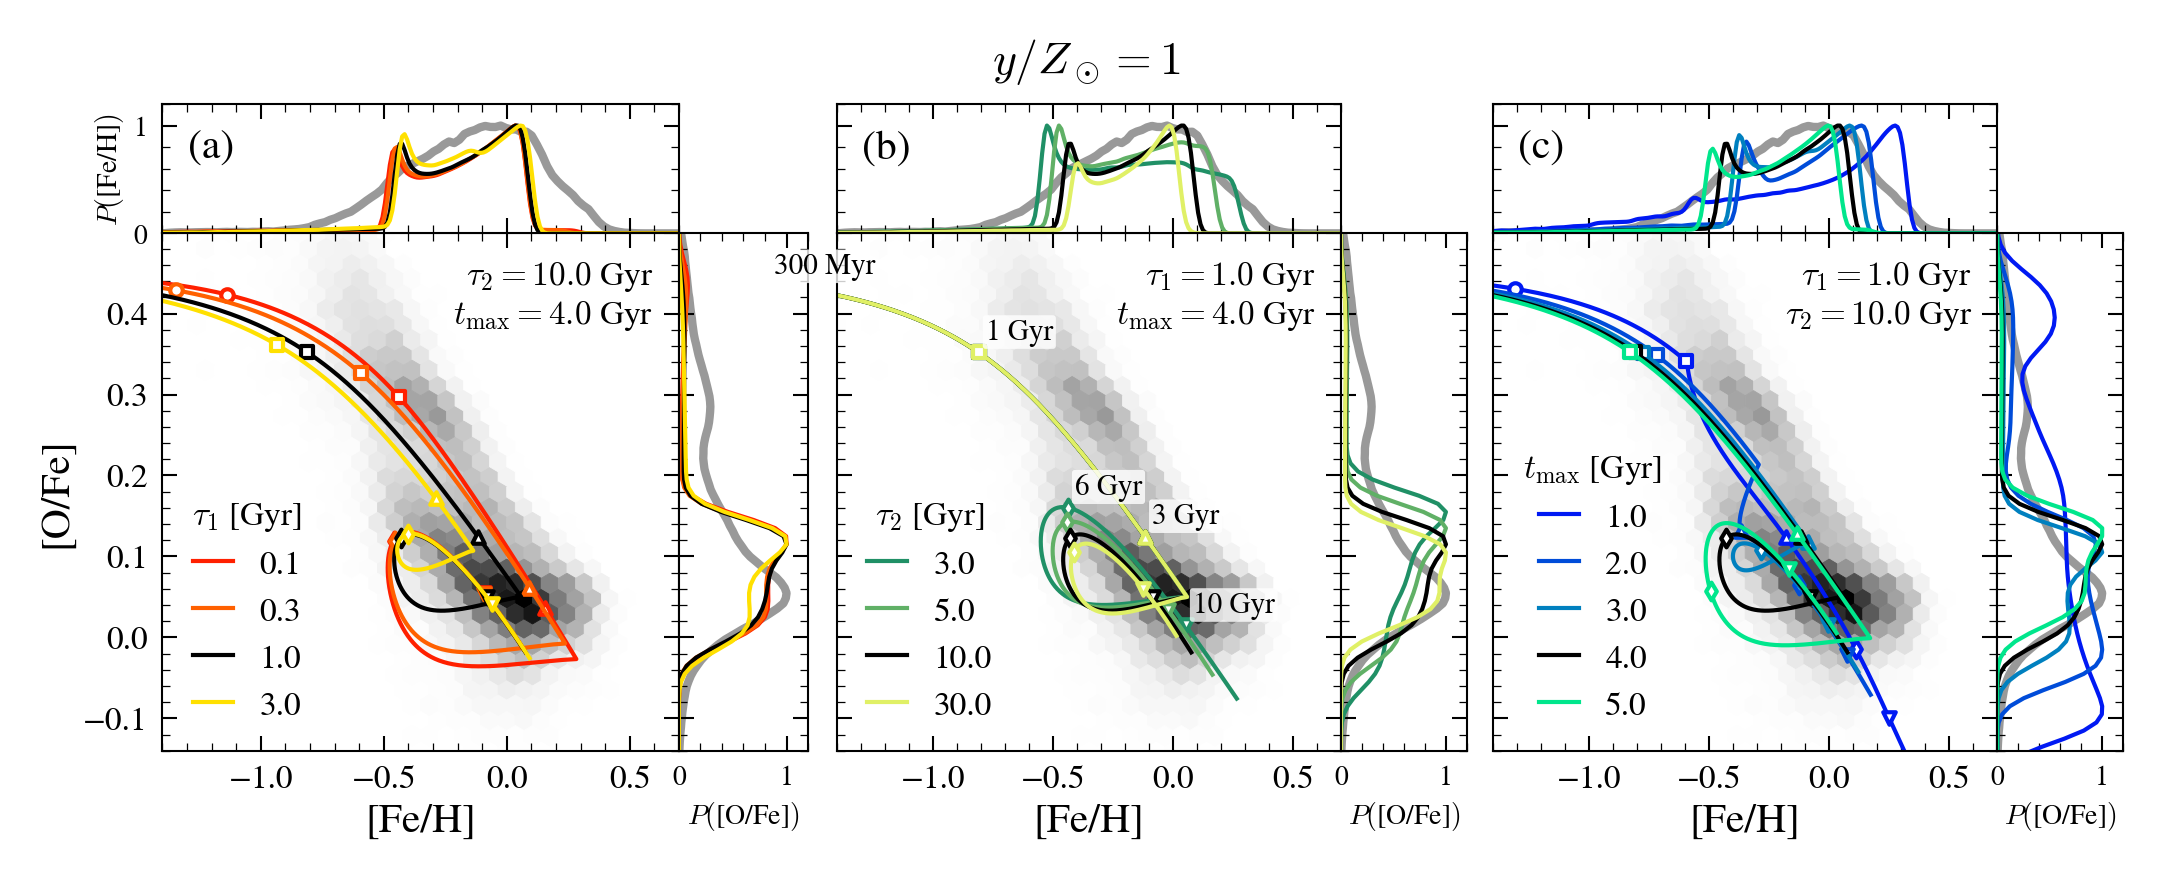

In [ ]:
from multizone.src.yields import yZ1
eta_func = outflows.yZ1

# fiducial model parameters in each panel
fiducial = {
    'first_timescale': 1.,
    'second_timescale': 10.,
    'onset': 4.
}
xlim = (-1.9, 0.7)
ylim = (-0.14, 0.499)

# Set up figure and subfigures
fig = plt.figure(figsize=(TWO_COLUMN_WIDTH, 0.4*TWO_COLUMN_WIDTH))
gs = fig.add_gridspec(5, 16, wspace=0.)
subfigs = [
    fig.add_subfigure(gs[:,i:i+w]) for i, w in zip((0, 6, 11), (6, 5, 5))
]
# First panel: vary tau_1
axs0 = vary_param(
    subfigs[0], 
    first_timescale=[0.1, 0.3, 1, 3], 
    fiducial_index=2,
    second_timescale=fiducial['second_timescale'], 
    onset=fiducial['onset'],
    eta_func=eta_func,
    xlim=xlim, ylim=ylim, 
    label_index=None, 
    cmap_name='autumn', 
    title='(a)'
)
# Second panel: vary tau_2
axs1 = vary_param(
    subfigs[1], 
    second_timescale=[3, 5, 10, 30],
    fiducial_index=2,
    first_timescale=fiducial['first_timescale'], 
    onset=fiducial['onset'],
    eta_func=eta_func,
    xlim=xlim, ylim=ylim, 
    show_ylabel=False,
    label_index=0, 
    cmap_name='summer', 
    title='(b)'
)
# Third panel: vary t_on
axs2 = vary_param(
    subfigs[2], 
    onset=[1, 2, 3, 4, 5],
    fiducial_index=3,
    first_timescale=fiducial['first_timescale'], 
    second_timescale=fiducial['second_timescale'],
    xlim=xlim, ylim=ylim, 
    eta_func=eta_func,
    show_ylabel=False,
    label_index=None, 
    cmap_name='winter', 
    title='(c)'
)
# Plot APOGEE data in each panel
apogee_sample = APOGEESample.load()
apogee_solar = apogee_sample.region(galr_lim=(7, 9), absz_lim=(0, 2))
cmap_name = 'binary'
data_color = '0.6'
for axs in [axs0, axs1, axs2]:
    pcm = axs[0].hexbin(
        apogee_solar('FE_H'), apogee_solar('O_FE'),
        gridsize=GRIDSIZE,
        extent=[xlim[0], xlim[1], ylim[0], ylim[1]],
        cmap=cmap_name, linewidths=0.2, zorder=0
    )
    # Plot APOGEE abundance distributions in marginal panels
    feh_df, feh_bin_edges = apogee_solar.mdf(
        col='FE_H', range=xlim, smoothing=SMOOTH_WIDTH
    )
    axs[1].plot(
        get_bin_centers(feh_bin_edges), feh_df / max(feh_df), 
        color=data_color, linestyle='-', linewidth=2, marker=None, zorder=0
    )
    ofe_df, ofe_bin_edges = apogee_solar.mdf(
        col='O_FE', range=ylim, smoothing=SMOOTH_WIDTH
    )
    axs[2].plot(
        ofe_df / max(ofe_df), get_bin_centers(ofe_bin_edges),
        color=data_color, linestyle='-', linewidth=2, marker=None, zorder=0
    )
plt.subplots_adjust(
    bottom=0.13, top=0.9, left=0.16, right=0.98, wspace=0.5
)
fig.suptitle(r'$y/Z_\odot=1$')
plt.show()

## Theoretical yield scale $(y/Z_\odot = 2)$

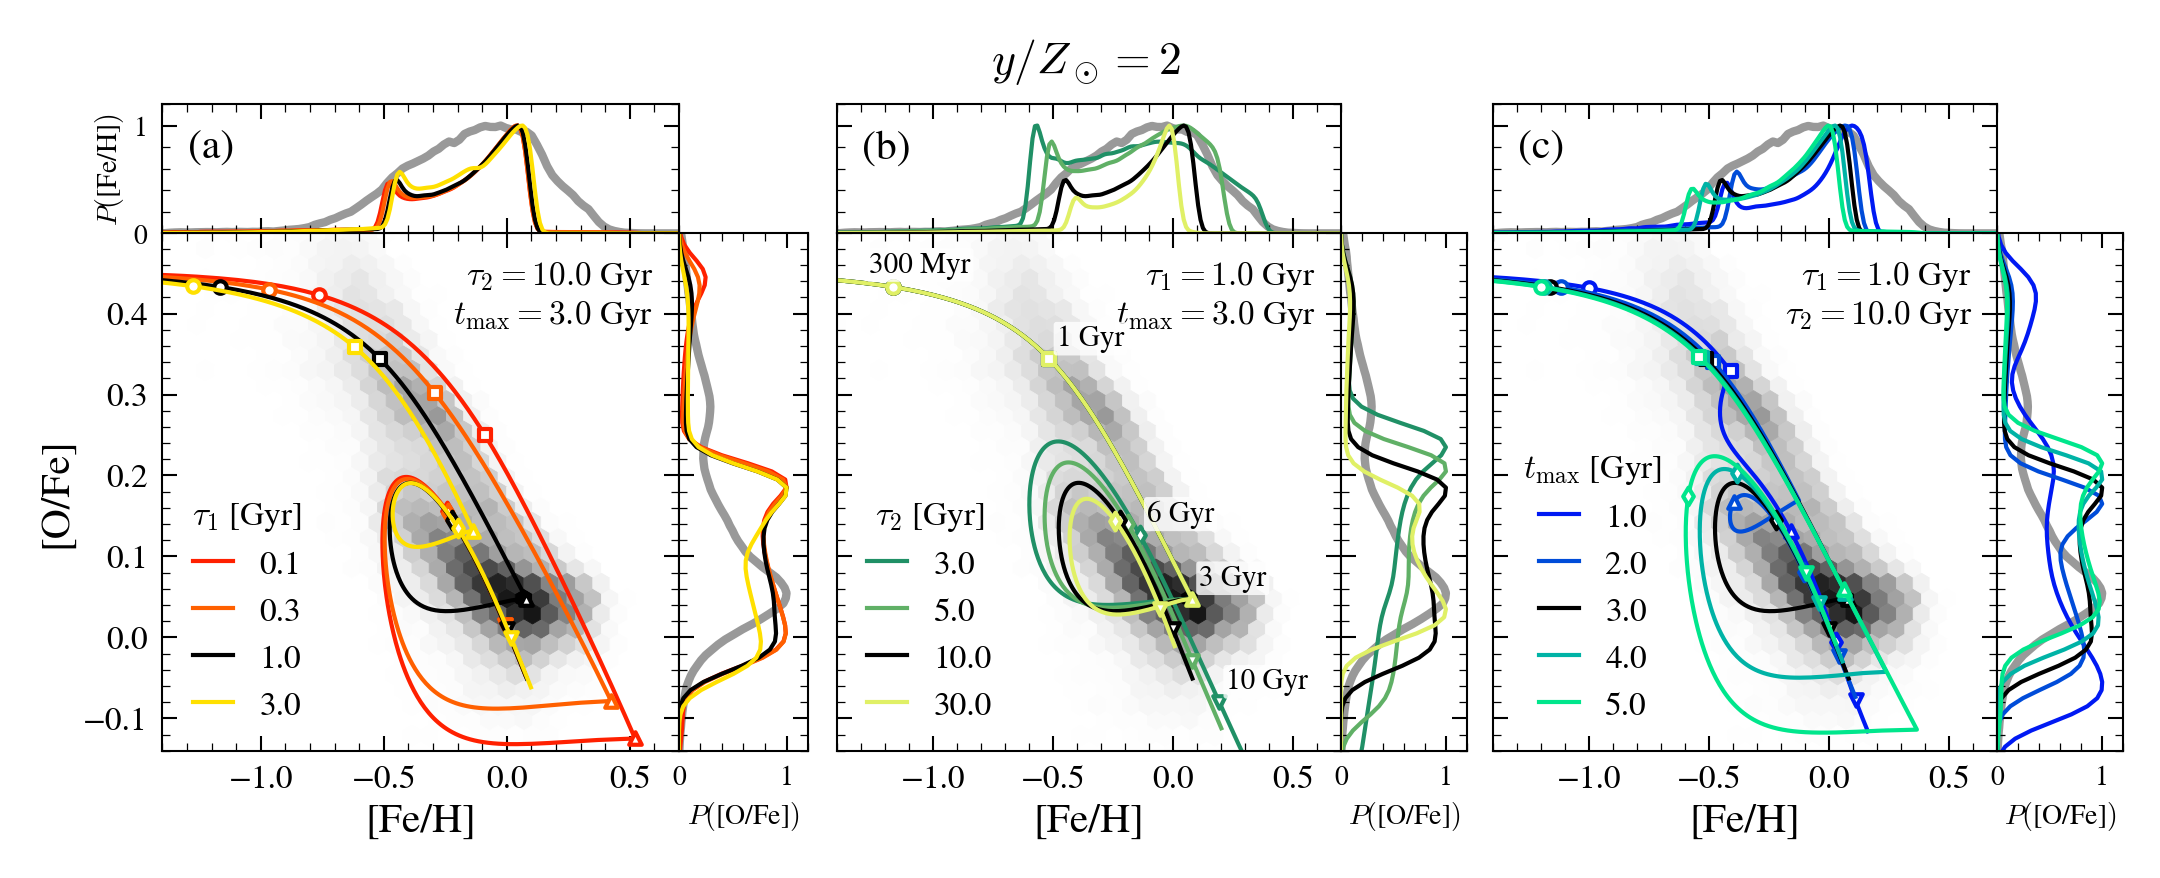

In [5]:
from multizone.src.yields import yZ2
eta_func = outflows.yZ2

# fiducial model parameters in each panel
fiducial = {
    'first_timescale': 1.,
    'second_timescale': 10.,
    'onset': 3.
}
xlim = (-1.4, 0.7)
ylim = (-0.14, 0.499)

# Set up figure and subfigures
fig = plt.figure(figsize=(TWO_COLUMN_WIDTH, 0.4*TWO_COLUMN_WIDTH))
gs = fig.add_gridspec(5, 16, wspace=0.)
subfigs = [
    fig.add_subfigure(gs[:,i:i+w]) for i, w in zip((0, 6, 11), (6, 5, 5))
]
# First panel: vary tau_1
axs0 = vary_param(
    subfigs[0], 
    first_timescale=[0.1, 0.3, 1, 3], 
    fiducial_index=2,
    second_timescale=fiducial['second_timescale'], 
    onset=fiducial['onset'],
    eta_func=eta_func,
    xlim=xlim, ylim=ylim, 
    label_index=None, 
    cmap_name='autumn', 
    title='(a)'
)
# Second panel: vary tau_2
axs1 = vary_param(
    subfigs[1], 
    second_timescale=[3, 5, 10, 30],
    fiducial_index=2,
    first_timescale=fiducial['first_timescale'], 
    onset=fiducial['onset'],
    eta_func=eta_func,
    xlim=xlim, ylim=ylim, 
    show_ylabel=False,
    label_index=0, 
    cmap_name='summer', 
    title='(b)'
)
# Third panel: vary t_on
axs2 = vary_param(
    subfigs[2], 
    onset=[1, 2, 3, 4, 5],
    fiducial_index=2,
    first_timescale=fiducial['first_timescale'], 
    second_timescale=fiducial['second_timescale'],
    xlim=xlim, ylim=ylim, 
    eta_func=eta_func,
    show_ylabel=False,
    label_index=None, 
    cmap_name='winter', 
    title='(c)'
)
# Plot APOGEE data in each panel
apogee_sample = APOGEESample.load()
apogee_solar = apogee_sample.region(galr_lim=(7, 9), absz_lim=(0, 2))
cmap_name = 'binary'
data_color = '0.6'
for axs in [axs0, axs1, axs2]:
    pcm = axs[0].hexbin(
        apogee_solar('FE_H'), apogee_solar('O_FE'),
        gridsize=GRIDSIZE,
        extent=[xlim[0], xlim[1], ylim[0], ylim[1]],
        cmap=cmap_name, linewidths=0.2, zorder=0
    )
    # Plot APOGEE abundance distributions in marginal panels
    feh_df, feh_bin_edges = apogee_solar.mdf(
        col='FE_H', range=xlim, smoothing=SMOOTH_WIDTH
    )
    axs[1].plot(
        get_bin_centers(feh_bin_edges), feh_df / max(feh_df), 
        color=data_color, linestyle='-', linewidth=2, marker=None, zorder=0
    )
    ofe_df, ofe_bin_edges = apogee_solar.mdf(
        col='O_FE', range=ylim, smoothing=SMOOTH_WIDTH
    )
    axs[2].plot(
        ofe_df / max(ofe_df), get_bin_centers(ofe_bin_edges),
        color=data_color, linestyle='-', linewidth=2, marker=None, zorder=0
    )
plt.subplots_adjust(
    bottom=0.13, top=0.9, left=0.16, right=0.98, wspace=0.5
)
fig.suptitle(r'$y/Z_\odot=2$')
plt.show()

## Extreme yield scale $(y/Z_\odot = 3)$

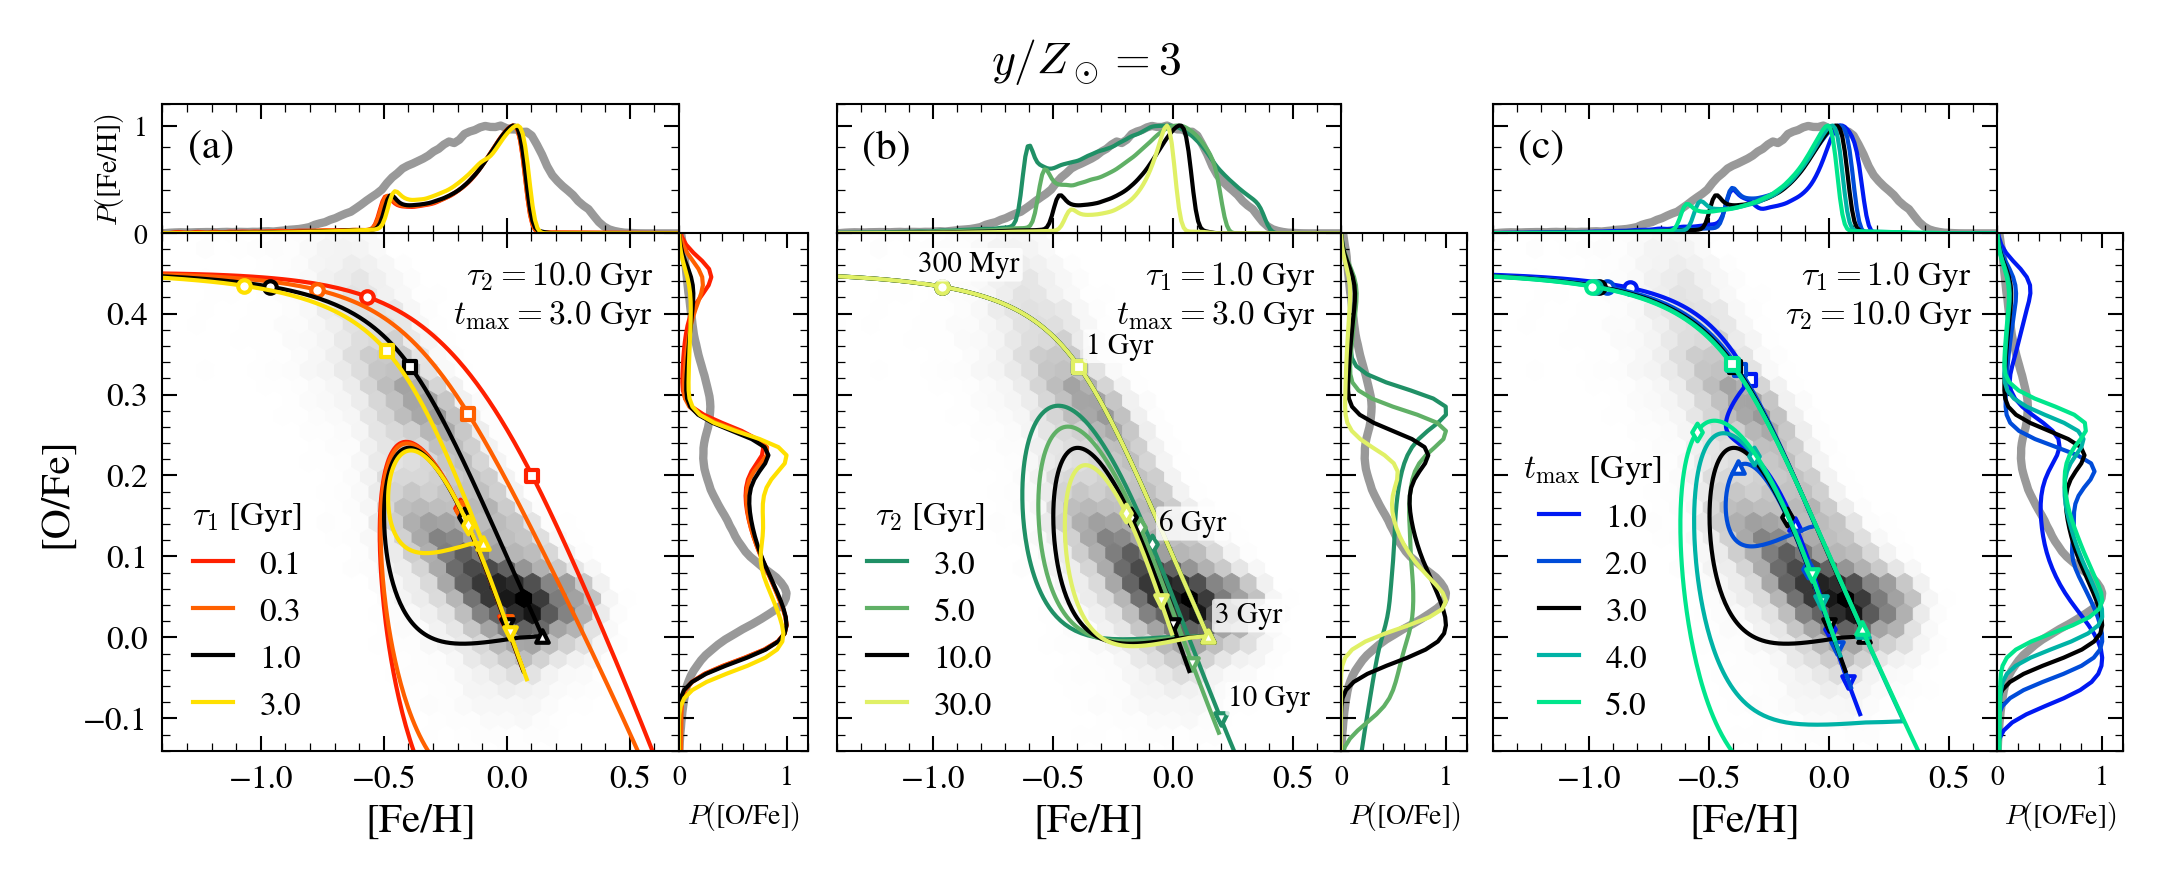

In [8]:
from multizone.src.yields import yZ3
eta_func = outflows.yZ3

# fiducial model parameters in each panel
fiducial = {
    'first_timescale': 1.,
    'second_timescale': 10.,
    'onset': 3.
}
xlim = (-1.4, 0.7)
ylim = (-0.14, 0.499)

# Set up figure and subfigures
fig = plt.figure(figsize=(TWO_COLUMN_WIDTH, 0.4*TWO_COLUMN_WIDTH))
gs = fig.add_gridspec(5, 16, wspace=0.)
subfigs = [
    fig.add_subfigure(gs[:,i:i+w]) for i, w in zip((0, 6, 11), (6, 5, 5))
]
# First panel: vary tau_1
axs0 = vary_param(
    subfigs[0], 
    first_timescale=[0.1, 0.3, 1, 3], 
    fiducial_index=2,
    second_timescale=fiducial['second_timescale'], 
    onset=fiducial['onset'],
    eta_func=eta_func,
    xlim=xlim, ylim=ylim, 
    label_index=None, 
    cmap_name='autumn', 
    title='(a)'
)
# Second panel: vary tau_2
axs1 = vary_param(
    subfigs[1], 
    second_timescale=[3, 5, 10, 30],
    fiducial_index=2,
    first_timescale=fiducial['first_timescale'], 
    onset=fiducial['onset'],
    eta_func=eta_func,
    xlim=xlim, ylim=ylim, 
    show_ylabel=False,
    label_index=0, 
    cmap_name='summer', 
    title='(b)'
)
# Third panel: vary t_on
axs2 = vary_param(
    subfigs[2], 
    onset=[1, 2, 3, 4, 5],
    fiducial_index=2,
    first_timescale=fiducial['first_timescale'], 
    second_timescale=fiducial['second_timescale'],
    xlim=xlim, ylim=ylim, 
    eta_func=eta_func,
    show_ylabel=False,
    label_index=None, 
    cmap_name='winter', 
    title='(c)'
)
# Plot APOGEE data in each panel
apogee_sample = APOGEESample.load()
apogee_solar = apogee_sample.region(galr_lim=(7, 9), absz_lim=(0, 2))
cmap_name = 'binary'
data_color = '0.6'
for axs in [axs0, axs1, axs2]:
    pcm = axs[0].hexbin(
        apogee_solar('FE_H'), apogee_solar('O_FE'),
        gridsize=GRIDSIZE,
        extent=[xlim[0], xlim[1], ylim[0], ylim[1]],
        cmap=cmap_name, linewidths=0.2, zorder=0
    )
    # Plot APOGEE abundance distributions in marginal panels
    feh_df, feh_bin_edges = apogee_solar.mdf(
        col='FE_H', range=xlim, smoothing=SMOOTH_WIDTH
    )
    axs[1].plot(
        get_bin_centers(feh_bin_edges), feh_df / max(feh_df), 
        color=data_color, linestyle='-', linewidth=2, marker=None, zorder=0
    )
    ofe_df, ofe_bin_edges = apogee_solar.mdf(
        col='O_FE', range=ylim, smoothing=SMOOTH_WIDTH
    )
    axs[2].plot(
        ofe_df / max(ofe_df), get_bin_centers(ofe_bin_edges),
        color=data_color, linestyle='-', linewidth=2, marker=None, zorder=0
    )
plt.subplots_adjust(
    bottom=0.13, top=0.9, left=0.16, right=0.98, wspace=0.5
)
fig.suptitle(r'$y/Z_\odot=3$')
plt.show()